# Maximum Memory Capacity versus driving voltage

Take the  memory capacity from the maximum perfromance parameter point, and plots it as a function of driving voltage



In [1]:
import matplotlib.pyplot as plt
from os import listdir
from pandas import read_excel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from itertools import cycle


V = [2.5, 3, 3.5 , 4, 4.25, 4.5, 5, 6]

In [2]:
def fit_data(reservoir_states, target, order):
    sync = order - 1
    alphas = np.arange(0.000000001, 0.1, 0.01)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    output_network = RidgeCV(alphas = alphas, cv = cv)
    
    # scale and save the training data
    trained_data = reservoir_states[sync:len(target)+sync, 0:127]
    # Train the output network.
    output_network = output_network.fit(trained_data, target)
    
    return output_network.score(trained_data, target), output_network

def parity_success_rate(output, target):
    binary_output = []
    halfway = (max(target) - min(target)) / 2
    for symbol in output:
        if symbol > halfway:
            binary_output.append(1)
        else:
            binary_output.append(0)
    success = 0
    for i in range(len(target)):
        if binary_output[i] == target[i]:
            success += 1

    return success / len(target)

def mutual_information_parity(sr):
    if sr == 1.0:
        return sr*np.log2(2*sr)
    else:
        return sr*np.log2(2*sr) + (1-sr)*np.log2(2*(1-sr))
    
def calculate_parity_stream(bit_stream, order, delta):
    parity_stream = np.array([])
    for i in range(delta):
        parity_stream = np.append(parity_stream, 0)
    for i in range(order + delta - 1, len(bit_stream)):
        parity_sum = 0
        for ii in range(order):
            parity_sum += float(bit_stream[i - delta - ii])
        parity = parity_sum % 2
        parity_stream = np.append(parity_stream, parity)
        
    return parity_stream

In [3]:
# Loads the identified high performance reservoir computer
ampl_axis = []
freqeuncy_axis = []
data_axis = []

for ampl in V:
    ampl_axis.append(ampl)
    data_axis.append(read_excel(f'../Data {ampl}V Driving/3.68421052631579e-05-nodes-39110526.xlsx', index_col = None))
    

In [10]:
# Calculates the memory capacity of the reservoir states
order = [2]
delta = np.arange(8,-1,-1)

r2_axis = {1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
p_axis =  {1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
mc_axis = {1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
mi_axis = {1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
train_until = 1000


for test in order:
    print(test)
    for dat in data_axis:
        MI = []
        #calculating the mutual information/memory capcaity
        for d in delta:
            parity_stream = calculate_parity_stream(dat["inputs"], test, d)
            arry = dat.to_numpy()[:,1:-1]
            r2, net = fit_data(arry, parity_stream[:train_until], test)
            end= len(parity_stream)
            sr = parity_success_rate(net.predict(arry[train_until - end:,:]), parity_stream[train_until - end:])
            #print(f"Delay:{d},R^2:{r2}, Surccess Rate: {sr})")
            mi = mutual_information_parity(sr)
            MI.append(mi)
        mi_axis[test].append(MI)
        mc_axis[test].append(np.sum(MI))
        p_axis[test].append(sr)
        r2_axis[test].append(r2)
        

2


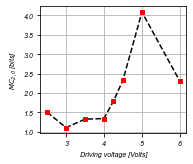

In [22]:
mpl.rcParams.update({'font.size': 7})
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.style'] = "italic"

fig, ax = plt.subplots(1,1, figsize = (2.7,2.3))
ax.plot(V, mc_axis[2], 'k--')
ax.plot(V, mc_axis[2], 'rs', markersize=4)
plt.grid('both')
plt.ylabel("$MC_{2,0}$ [bits]")
plt.xlabel("Driving voltage [Volts]")

plt.tight_layout()
plt.savefig('driving_voltage_versus_memory.png', dpi=500)